<a href="https://colab.research.google.com/github/MartaCampagnoli/PageRank-MovieActors/blob/main/Original%20Notebooks%20(Local%20Files)/PageRank_Movie_Actors_Network_(Local).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PageRank

The following part is based on an adaptation of the code for the Page Rank algorithm seen during the course and tutoring lessons. Particularly, I found that the adaptation of the code that removes the Euclidean distance function and only bases the iterations on a range lenght (as seen during tutoring) works on both the small network of 23 nodes (movies) and two actors and a network of 8461 nodes (2020-2021 dataset).

When using the algorithm as seen in class the adaptation only works on the small network, due to an error in the computation of the Euclidean distance. For completeness reasons, I decided to keep the implementation in the project to show my attempt at implementing the solution.

For scaling up replicability, the algorithms have been implemented using Spark.

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar xf spark-3.3.1-bin-hadoop3.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/spark-3.3.1-bin-hadoop3"

import findspark
findspark.init("spark-3.3.1-bin-hadoop3")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

sc = spark.sparkContext

In [ ]:
import pandas as pd
import io
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure
figure(figsize=(100, 100), dpi=80)
from networkx import pagerank

<Figure size 8000x8000 with 0 Axes>

# PageRank (Iterations only) on small network

In [ ]:
from google.colab import files 
titles = files.upload()

Saving titlesjemtaika.json to titlesjemtaika.json


In [ ]:
titles = pd.read_json(io.StringIO(titles.get('titlesjemtaika.json').decode('utf-8')))

In [ ]:
titles = list(titles[0])

In [ ]:
nodes = range(len(titles))
nodes_index = {p: l for p, l in zip(nodes, titles)}
nodes_index

{0: 'An American in Whakataki',
 1: 'An Evening with Beverly Luff Linn',
 2: 'Avatar 5',
 3: 'Boy',
 4: 'Don Verdean',
 5: 'Eagle vs Shark',
 6: 'Free Guy',
 7: 'Frodo Is Great... Who Is That?!!',
 8: 'Gentlemen Broncos',
 9: 'I Used to Go Here',
 10: 'Jojo Rabbit',
 11: 'Lightyear',
 12: 'Men in Black 3',
 13: 'Nude Tuesday',
 14: 'Patrick',
 15: 'People Places Things',
 16: 'Predicament',
 17: 'Rio 2',
 18: 'Scarfies',
 19: 'Seven Stages to Achieve Eternal Bliss',
 20: 'The BFG',
 21: 'Tongan Ninja',
 22: 'What We Do in the Shadows'}

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving taikajemcountminusone.json to taikajemcountminusone.json


In [ ]:
df = pd.read_json(io.StringIO(uploaded.get('taikajemcountminusone.json').decode('utf-8')))

In [ ]:
l1 = list(zip(df[0], df[1])) #creating links

In [ ]:
g = nx.DiGraph()

for p in nodes:
    g.add_node(p)

for (a, b) in l1:
    g.add_edge(nodes[a], nodes[b])

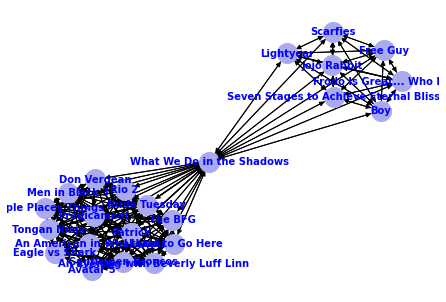

In [ ]:
opts = {'node_size': 400, 
        'font_color': 'b',
        'font_size': 10,
        'font_weight': 'bold'}

nx.draw(g, with_labels=True, labels=nodes_index,
       node_color='#AAAAEE', **opts)
plt.show()

In [ ]:
dataset = sc.parallelize(l1).cache()

In [ ]:
total_movies = max(dataset.max(lambda x:x[0])[0],dataset.max(lambda x:x[1])[1])
print(total_movies) #counting nodes by index: the indeces start from 0 so we have 23 movies

22


In [ ]:
outdegree = dataset.countByKey() #computing outdegree
outdegree[0], outdegree[2], outdegree[18], outdegree[22]

(15, 15, 7, 22)

In [ ]:

P = dataset.map(lambda x:(x[0],x[1],1/outdegree[x[0]]))
P.take(20) #connection matrix

[(0, 1, 0.06666666666666667),
 (0, 2, 0.06666666666666667),
 (0, 4, 0.06666666666666667),
 (0, 5, 0.06666666666666667),
 (0, 8, 0.06666666666666667),
 (0, 9, 0.06666666666666667),
 (0, 12, 0.06666666666666667),
 (0, 13, 0.06666666666666667),
 (0, 14, 0.06666666666666667),
 (0, 15, 0.06666666666666667),
 (0, 16, 0.06666666666666667),
 (0, 17, 0.06666666666666667),
 (0, 20, 0.06666666666666667),
 (0, 21, 0.06666666666666667),
 (0, 22, 0.06666666666666667),
 (1, 0, 0.06666666666666667),
 (1, 2, 0.06666666666666667),
 (1, 4, 0.06666666666666667),
 (1, 5, 0.06666666666666667),
 (1, 8, 0.06666666666666667)]

In [ ]:
import numpy as np
p = np.full((total_movies+1,), 1/(total_movies+1))
p[:10] #setting probability vector

array([0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826])

In [ ]:
# inverting the order of nodes in the matrix
PT = P.map(lambda x: (x[1],x[0],x[2]))

The number of iterations is kept small because we are dealing with a very small network; we will see in the PageRank with Euclidean distance that the algorithm automatically stops at 17 iterations.

In [ ]:
#computing pagerank
for i in range(50):
    new_p = PT.map(lambda x:(x[0],(x[2]*p[x[1]])))\
              .reduceByKey(lambda x,y: x+y)\
              .collect()
    for idx,prb in new_p:
        p[idx] = prb
    
    print(f"iteration {i}")


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49


In [ ]:
list(zip(p.argsort()[::-1], p[p.argsort()[::-1]])) #showing results by value. they resemble the ones computed on the same graph through Networkx

[(22, 0.07434390743481965),
 (12, 0.05065810289007957),
 (1, 0.05065810289007957),
 (2, 0.05065810289007957),
 (4, 0.05065810289007957),
 (5, 0.05065810289007957),
 (8, 0.05065810289007957),
 (9, 0.05065810289007957),
 (21, 0.05065810289007957),
 (0, 0.05065810289007957),
 (13, 0.05065810289007957),
 (14, 0.05065810289007957),
 (15, 0.05065810289007957),
 (16, 0.05065810289007957),
 (17, 0.05065810289007957),
 (20, 0.05065810289007957),
 (10, 0.023683507030569467),
 (7, 0.023683507030569467),
 (6, 0.023683507030569467),
 (18, 0.023683507030569467),
 (3, 0.023683507030569467),
 (19, 0.023683507030569467),
 (11, 0.023683507030569467)]

Checking the index with the source dataset containing movies and their corresponding index (as done in the next example) we would see that this result is coherent with reality; node 22 corresponds to "What We Do in The Shadows" the only movie that has higher probability to be reached, since it's connected to movies where both Taika Waititi and Jemaine Clement acted in. It is in fact the only movie where the two worked together as actors. The following image shows the graph colored by pagerank value.

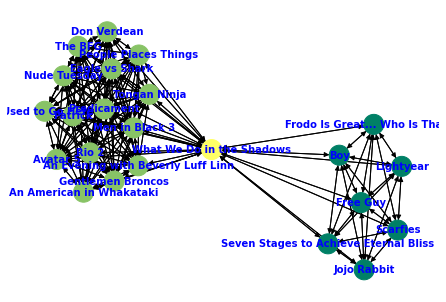

In [ ]:
nx.draw(g, with_labels=True, labels=nodes_index,
        node_color=p, cmap=plt.cm.summer, **opts)
plt.show()

# PageRank (Iterations only) on 2020-2021 movies Network

The following code has been run on a larger dataset with 8641 movies, with actors that have only acted in one movie released in the 2020-2021 years removed.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ventiventuno.json to ventiventuno.json


In [ ]:
df = pd.read_json(io.StringIO(uploaded.get('ventiventuno.json').decode('utf-8')))

In [ ]:
l1 = list(zip(df[0], df[1]))

In [ ]:
dataset = sc.parallelize(l1).cache()

In [ ]:
total_movies = max(dataset.max(lambda x:x[0])[0],dataset.max(lambda x:x[1])[1])
print(total_movies)

8460


In [ ]:
outdegree = dataset.countByKey()

In [ ]:
P = dataset.map(lambda x:(x[0],x[1],1/outdegree[x[0]]))
P.take(20)

[(0, 8092, 0.3333333333333333),
 (0, 4899, 0.3333333333333333),
 (0, 6579, 0.3333333333333333),
 (1, 3279, 0.16666666666666666),
 (1, 3279, 0.16666666666666666),
 (1, 3279, 0.16666666666666666),
 (1, 3279, 0.16666666666666666),
 (1, 3279, 0.16666666666666666),
 (1, 3279, 0.16666666666666666),
 (2, 3784, 0.2),
 (2, 3697, 0.2),
 (2, 642, 0.2),
 (2, 3678, 0.2),
 (2, 6253, 0.2),
 (3, 4236, 0.5),
 (3, 4236, 0.5),
 (4, 470, 0.05263157894736842),
 (4, 684, 0.05263157894736842),
 (4, 1384, 0.05263157894736842),
 (4, 3080, 0.05263157894736842)]

In [ ]:
p = np.full((total_movies+1,), 1/(total_movies+1))
p[:10]

array([0.00011819, 0.00011819, 0.00011819, 0.00011819, 0.00011819,
       0.00011819, 0.00011819, 0.00011819, 0.00011819, 0.00011819])

In [ ]:
PT = P.map(lambda x: (x[1],x[0],x[2]))   

In [ ]:
for i in range(1000): #takes approximately 5/7 minutes 
    new_p = PT.map(lambda x:(x[0],(x[2]*p[x[1]])))\
              .reduceByKey(lambda x,y: x+y)\
              .collect()
    for idx,prb in new_p:
        p[idx] = prb

In [ ]:
list(zip(p.argsort()[::-1], p[p.argsort()[::-1]])) #sorted results, output removed for space reason. top value (4442, 0.002052534354076937)

Because the dataset has been sorted by name, we can retrieve the movie titles of the highest result by either accessing a list of title by index of by creating a dictionary of titles. Both methods bring the same result.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving titles2021.json to titles2021.json


In [ ]:
titles = pd.read_json(io.StringIO(uploaded.get('titles2021.json').decode('utf-8')))

In [ ]:
titles[0][4442]

'Mission: The Prophet'

Dictionary alternative:

In [ ]:
titles2 = list(titles[0].values.tolist())

In [ ]:
titles2 # output removed for space reason

In [ ]:
movies = range(len(titles2))
movie_titles = {p: l for p, l in zip(movies, titles2)}
movie_titles #output removed for space reason.

In [ ]:
movie_titles[4442]

'Mission: The Prophet'

#PageRank Euclidean Distance Small network

After defining the Euclidean distance function, we see that the process as seen is class, adapted for this dataset, works on the small dataset leading to similar results.

In [ ]:
def l2distance(v, q):
    
    if len(v) != len(q):
        raise ValueError('Vectors of different lenght'
                         ' error')
    
    return sum([(q_el - v_el)**2 for v_el, q_el in zip(v, q)])

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving taikajemcountminusone.json to taikajemcountminusone (2).json


In [ ]:
df = pd.read_json(io.StringIO(uploaded.get('taikajemcountminusone.json').decode('utf-8')))

In [ ]:
l1 = list(zip(df[0], df[1]))

In [ ]:
dataset = sc.parallelize(l1).cache()

In [ ]:
total_movies = max(dataset.max(lambda x:x[0])[0],dataset.max(lambda x:x[1])[1])
print(total_movies)

22


In [ ]:
outdegree = dataset.countByKey()

In [ ]:
P = dataset.map(lambda x:(x[0],x[1],1/outdegree[x[0]]))
P.take(20)

[(0, 1, 0.06666666666666667),
 (0, 2, 0.06666666666666667),
 (0, 4, 0.06666666666666667),
 (0, 5, 0.06666666666666667),
 (0, 8, 0.06666666666666667),
 (0, 9, 0.06666666666666667),
 (0, 12, 0.06666666666666667),
 (0, 13, 0.06666666666666667),
 (0, 14, 0.06666666666666667),
 (0, 15, 0.06666666666666667),
 (0, 16, 0.06666666666666667),
 (0, 17, 0.06666666666666667),
 (0, 20, 0.06666666666666667),
 (0, 21, 0.06666666666666667),
 (0, 22, 0.06666666666666667),
 (1, 0, 0.06666666666666667),
 (1, 2, 0.06666666666666667),
 (1, 4, 0.06666666666666667),
 (1, 5, 0.06666666666666667),
 (1, 8, 0.06666666666666667)]

In [ ]:
PT = P.map(lambda x: (x[1],x[0],x[2]))

In [ ]:
page_rank = np.ones(total_movies+1)/(total_movies+1)
old_page_rank = np.ones(total_movies+1)

In [ ]:
page_rank

array([0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826, 0.04347826, 0.04347826,
       0.04347826, 0.04347826, 0.04347826])

In [ ]:
tolerance = 10e-7
max_iterations = 1000

iteration = 0
while l2distance(old_page_rank, page_rank) >= tolerance and \
      iteration < max_iterations:
    old_page_rank = page_rank
    
    page_rank_values = (PT
                        .map(lambda t: (t[0], t[2]*page_rank[t[1]]))
                        .reduceByKey(lambda a, b: a+b)
                        .sortByKey()
                        .collect()
                       )
    
    page_rank = np.array([c for (i, c) in page_rank_values])
    
    print(page_rank)

    iteration += 1

[0.04255599 0.04255599 0.04255599 0.03924337 0.04255599 0.04255599
 0.03924337 0.03924337 0.04255599 0.04255599 0.03924337 0.03924337
 0.04255599 0.04255599 0.04255599 0.04255599 0.04255599 0.04255599
 0.03924337 0.03924337 0.04255599 0.04255599 0.08695652]
[0.0436715  0.0436715  0.0436715  0.03758974 0.0436715  0.0436715
 0.03758974 0.03758974 0.0436715  0.0436715  0.03758974 0.03758974
 0.0436715  0.0436715  0.0436715  0.0436715  0.0436715  0.0436715
 0.03758974 0.03758974 0.0436715  0.0436715  0.08179936]
[0.04447822 0.04447822 0.04447822 0.03593793 0.04447822 0.04447822
 0.03593793 0.03593793 0.04447822 0.04447822 0.03593793 0.03593793
 0.04447822 0.04447822 0.04447822 0.04447822 0.04447822 0.04447822
 0.03593793 0.03593793 0.04447822 0.04447822 0.08126124]
[0.0452067  0.0452067  0.0452067  0.03449763 0.0452067  0.0452067
 0.03449763 0.03449763 0.0452067  0.0452067  0.03449763 0.03449763
 0.0452067  0.0452067  0.0452067  0.0452067  0.0452067  0.0452067
 0.03449763 0.03449763 0.0452

The result is indeed similar to the previous algorithm. Node 22 is still the node with highest value, and the the ranking of the following values is also the same.

In [ ]:
list(zip(page_rank.argsort()[::-1], page_rank[page_rank.argsort()[::-1]]))

[(22, 0.07552767673270142),
 (12, 0.049595854680234745),
 (1, 0.049595854680234745),
 (2, 0.049595854680234745),
 (4, 0.049595854680234745),
 (5, 0.049595854680234745),
 (8, 0.049595854680234745),
 (9, 0.049595854680234745),
 (21, 0.049595854680234745),
 (0, 0.049595854680234745),
 (13, 0.049595854680234745),
 (14, 0.049595854680234745),
 (15, 0.049595854680234745),
 (16, 0.049595854680234745),
 (17, 0.049595854680234745),
 (20, 0.049595854680234745),
 (10, 0.025790643294825326),
 (7, 0.025790643294825326),
 (6, 0.025790643294825326),
 (3, 0.025790643294825326),
 (11, 0.025790643294825326),
 (18, 0.025790643294825322),
 (19, 0.025790643294825322)]

In [ ]:
iteration #number of needed iterations

17

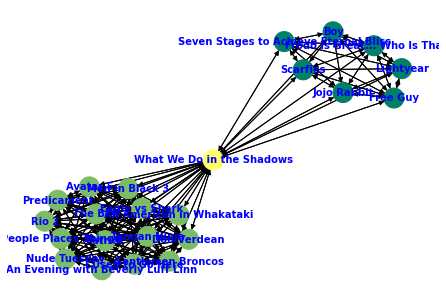

In [ ]:
nx.draw(g, with_labels=True, labels=nodes_index,
        node_color=page_rank, cmap=plt.cm.summer, **opts)
plt.show()

# PageRank with Euclidean distance and Taxation on a Small network

By nature of the network, it's impossible to have dangling nodes or spider traps; even though the network is directed, each edge exista in both directiona by definition, because we have connected movies if they share an actor, so the relationship is symmetrical. We can only have isolated components, and even though it is highly unlikely that a small group of movies does not share even a single acting credit with the main component of the network, we cannot exclude it completely, so we can run the algorithm with the taxation variation too. 

In [ ]:
#we re-inizialize the sparkcontext and data using the code in the previous section until the last step
tolerance = 10e-7
max_iterations = 1000

iteration = 0
while l2distance(old_page_rank, page_rank) >= tolerance and \
      iteration < max_iterations:
    beta = 0.8
    old_page_rank = page_rank
    
    page_rank_values = (PT
                        .map(lambda t: (t[0], t[2]*page_rank[t[1]]))
                        .reduceByKey(lambda a, b: a+b)
                        .sortByKey()
                        .collect()
                       )
    page_rank = np.array([beta*c + (1-beta)/(total_movies+1)
                              for (i, c) in page_rank_values])
    print(page_rank)

    iteration += 1

    

[0.04274045 0.04274045 0.04274045 0.04009034 0.04274045 0.04274045
 0.04009034 0.04009034 0.04274045 0.04274045 0.04009034 0.04009034
 0.04274045 0.04274045 0.04274045 0.04274045 0.04274045 0.04274045
 0.04009034 0.04009034 0.04274045 0.04274045 0.07826087]
[0.04345437 0.04345437 0.04345437 0.03903202 0.04345437 0.04345437
 0.03903202 0.03903202 0.04345437 0.04345437 0.03903202 0.03903202
 0.04345437 0.04345437 0.04345437 0.04345437 0.04345437 0.04345437
 0.03903202 0.03903202 0.04345437 0.04345437 0.07496029]
[0.04386741 0.04386741 0.04386741 0.0381863  0.04386741 0.04386741
 0.0381863  0.0381863  0.04386741 0.04386741 0.0381863  0.0381863
 0.04386741 0.04386741 0.04386741 0.04386741 0.04386741 0.04386741
 0.0381863  0.0381863  0.04386741 0.04386741 0.07468477]
[0.04416579 0.04416579 0.04416579 0.03759635 0.04416579 0.04416579
 0.03759635 0.03759635 0.04416579 0.04416579 0.03759635 0.03759635
 0.04416579 0.04416579 0.04416579 0.04416579 0.04416579 0.04416579
 0.03759635 0.03759635 0.0

In [ ]:
list(zip(page_rank.argsort()[::-1], page_rank[page_rank.argsort()[::-1]]))

[(22, 0.07552767673270142),
 (12, 0.049595854680234745),
 (1, 0.049595854680234745),
 (2, 0.049595854680234745),
 (4, 0.049595854680234745),
 (5, 0.049595854680234745),
 (8, 0.049595854680234745),
 (9, 0.049595854680234745),
 (21, 0.049595854680234745),
 (0, 0.049595854680234745),
 (13, 0.049595854680234745),
 (14, 0.049595854680234745),
 (15, 0.049595854680234745),
 (16, 0.049595854680234745),
 (17, 0.049595854680234745),
 (20, 0.049595854680234745),
 (10, 0.025790643294825326),
 (7, 0.025790643294825326),
 (6, 0.025790643294825326),
 (3, 0.025790643294825326),
 (11, 0.025790643294825326),
 (18, 0.025790643294825322),
 (19, 0.025790643294825322)]

In [ ]:
iteration #number of needed iterations

6

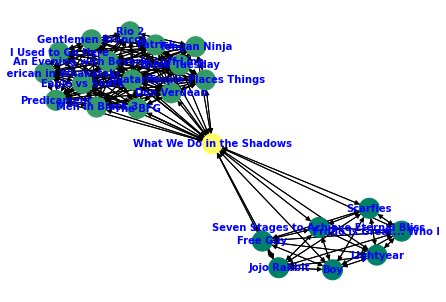

In [ ]:
nx.draw(g, with_labels=True, labels=nodes_index,
        node_color=page_rank, cmap=plt.cm.summer, **opts)
plt.show()

The result has the same ordering and very similar values, but needed less iterations to reach convergence.

#PageRank Euclidean distance Complete network

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ventiventuno.json to ventiventuno.json


In [ ]:
df = pd.read_json(io.StringIO(uploaded.get('ventiventuno.json').decode('utf-8')))

In [ ]:
l1 = list(zip(df[0], df[1]))

In [ ]:
dataset = sc.parallelize(l1).cache()

In [ ]:
total_movies = max(dataset.max(lambda x:x[0])[0],dataset.max(lambda x:x[1])[1])
print(total_movies)

8460


In [ ]:
outdegree = dataset.countByKey()

In [ ]:
P = dataset.map(lambda x:(x[1],x[0],1/outdegree[x[0]]))
P.take(20) #even directly creating the matrix and avoiding the inverting step, the Euclidean distance computation throws an error 

[(8092, 0, 0.3333333333333333),
 (4899, 0, 0.3333333333333333),
 (6579, 0, 0.3333333333333333),
 (3279, 1, 0.16666666666666666),
 (3279, 1, 0.16666666666666666),
 (3279, 1, 0.16666666666666666),
 (3279, 1, 0.16666666666666666),
 (3279, 1, 0.16666666666666666),
 (3279, 1, 0.16666666666666666),
 (3784, 2, 0.2),
 (3697, 2, 0.2),
 (642, 2, 0.2),
 (3678, 2, 0.2),
 (6253, 2, 0.2),
 (4236, 3, 0.5),
 (4236, 3, 0.5),
 (470, 4, 0.05263157894736842),
 (684, 4, 0.05263157894736842),
 (1384, 4, 0.05263157894736842),
 (3080, 4, 0.05263157894736842)]

In [ ]:
page_rank = np.ones((total_movies)+1)/((total_movies)+1)
old_page_rank = np.ones((total_movies)+1)

In [ ]:
page_rank

array([0.00011819, 0.00011819, 0.00011819, ..., 0.00011819, 0.00011819,
       0.00011819])

In [ ]:
tolerance = 10e-7
max_iterations = 1000

iteration = 0
while l2distance(old_page_rank, page_rank) >= tolerance and \
      iteration < max_iterations:
    old_page_rank = page_rank
    
    page_rank_values = (PT
                        .map(lambda t: (t[0], t[2]*page_rank[t[1]]))
                        .reduceByKey(lambda a, b: a+b)
                        .sortByKey()
                        .collect()
                       )
    
    page_rank = np.array([c for (i, c) in page_rank_values])
    
    print(page_rank)

    iteration += 1

[1.68330271e-04 1.18189339e-04 1.90416158e-04 ... 1.43137027e-04
 1.18189339e-04 3.93964464e-05]


ValueError: ignored